In [42]:
# Imports
from math import ceil
import torch
torch.backends.cudnn.benchmark = True
from torch import nn
import torch.nn.functional as F
import sys
sys.path.append('..')
import airbench
import torch.linalg as LA
from torch.cuda.amp import GradScaler


In [43]:
## Muon Optimizer
@torch.compile
def zeropower_via_newtonschulz5(G, steps=3, eps=1e-7):
    assert len(G.shape) == 2
    a, b, c = (3.4445, -4.7750,  2.0315)
    X = G.bfloat16()
    X /= (X.norm() + eps) # ensure top singular value <= 1
    if G.size(0) > G.size(1):
        X = X.T
    for _ in range(steps):
        A = X @ X.T
        B = b * A + c * A @ A
        X = a * X + B @ X
    if G.size(0) > G.size(1):
        X = X.T
    return X

class Muon(torch.optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0, nesterov=False):
        defaults = dict(lr=lr, momentum=momentum, nesterov=nesterov)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group["lr"]
            momentum = group["momentum"]
            for p in group["params"]:
                g = p.grad
                if g is None:
                    continue
                state = self.state[p]

                if "momentum_buffer" not in state.keys():
                    state["momentum_buffer"] = torch.zeros_like(g)
                buf = state["momentum_buffer"]
                buf.mul_(momentum).add_(g)
                g = g.add(buf, alpha=momentum) if group["nesterov"] else buf

                p.data.mul_(len(p.data)**0.5 / p.data.norm()) # normalize the weight
                update = zeropower_via_newtonschulz5(g.reshape(len(g), -1)).view(g.shape) # whiten the update
                p.data.add_(update, alpha=-lr) # take a step
                

In [44]:
## MODEL
# note the use of low BatchNorm stats momentum
class BatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, momentum=0.6, eps=1e-12):
        super().__init__(num_features, eps=eps, momentum=1-momentum)
        self.weight.requires_grad = False
        # Note that PyTorch already initializes the weights to one and bias to zero

class Conv(nn.Conv2d):
    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels, kernel_size=3, padding="same", bias=False)

    def reset_parameters(self):
        super().reset_parameters()
        w = self.weight.data
        torch.nn.init.dirac_(w[:w.size(1)])

class ConvGroup(nn.Module):
    def __init__(self, channels_in, channels_out):
        super().__init__()
        self.conv1 = Conv(channels_in,  channels_out)
        self.pool = nn.MaxPool2d(2)
        self.norm1 = BatchNorm(channels_out)
        self.conv2 = Conv(channels_out, channels_out)
        self.norm2 = BatchNorm(channels_out)
        self.activ = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.norm1(x)
        x = self.activ(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activ(x)
        return x

class CifarNet(nn.Module):
    def __init__(self):
        super().__init__()
        widths = dict(block1=64, block2=256, block3=256)
        whiten_kernel_size = 2
        whiten_width = 2 * 3 * whiten_kernel_size**2
        self.whiten = nn.Conv2d(3, whiten_width, whiten_kernel_size, padding=0, bias=True)
        self.whiten.weight.requires_grad = False
        self.layers = nn.Sequential(
            nn.GELU(),
            ConvGroup(whiten_width,     widths["block1"]),
            ConvGroup(widths["block1"], widths["block2"]),
            ConvGroup(widths["block2"], widths["block3"]),
            nn.MaxPool2d(3),
        )
        self.head = nn.Linear(widths["block3"], 10, bias=False)
        for mod in self.modules():
            if isinstance(mod, BatchNorm):
                mod.float()
            else:
                mod.half()

    def reset(self):
        for m in self.modules():
            if type(m) in (nn.Conv2d, Conv, BatchNorm, nn.Linear):
                m.reset_parameters()
        w = self.head.weight.data
        w *= 1 / w.std()

    def init_whiten(self, train_images, eps=5e-4):
        c, (h, w) = train_images.shape[1], self.whiten.weight.shape[2:]
        patches = train_images.unfold(2,h,1).unfold(3,w,1).transpose(1,3).reshape(-1,c,h,w).float()
        patches_flat = patches.view(len(patches), -1)
        est_patch_covariance = (patches_flat.T @ patches_flat) / len(patches_flat)
        eigenvalues, eigenvectors = torch.linalg.eigh(est_patch_covariance, UPLO="U")
        eigenvectors_scaled = eigenvectors.T.reshape(-1,c,h,w) / torch.sqrt(eigenvalues.view(-1,1,1,1) + eps)
        self.whiten.weight.data[:] = torch.cat((eigenvectors_scaled, -eigenvectors_scaled))

    def forward(self, x, whiten_bias_grad=True):
        b = self.whiten.bias
        x = F.conv2d(x, self.whiten.weight, b if whiten_bias_grad else b.detach())
        x = self.layers(x)
        x = x.view(len(x), -1)
        return self.head(x) / x.size(-1)

In [45]:
def compute_effective_rank_matrix(W: torch.Tensor):
    """
    Safe SVD-based rank estimates.  Any NaN/Inf in W get zeroed out.
    Returns (stable_rank, entropy_rank) as Python floats.
    """
    # 1) Flatten + cast + to CPU
    W2 = W.view(W.size(0), -1).float().cpu()
    # 2) Zero out any non-finite entries
    if not torch.isfinite(W2).all():
        W2 = torch.nan_to_num(W2, nan=0.0, posinf=0.0, neginf=0.0)

    # 3) Compute SVD on CPU
    try:
        _, s, _ = LA.svd(W2, full_matrices=False)
    except RuntimeError as e:
        # fallback: use eigenvalues of W W^T
        # W W^T has the same non-zero singular values squared
        cov = W2 @ W2.T
        eig = torch.linalg.eigvalsh(cov)
        s = torch.sqrt(torch.clamp(eig, min=0.0))

    # stable rank = sum(s_i^2) / max(s_i)^2
    stable = (s**2).sum() / (s.max()**2)
    # entropy-based rank = exp(-sum p_i log p_i), p_i = s_i / sum(s_i)
    p = s / s.sum()
    entropy = torch.exp(- (p * torch.log(p)).sum())

    return stable.item(), entropy.item()

In [46]:
stable_ranks = []
entropy_ranks = []
def train_muon():
    model = CifarNet().cuda().to(memory_format=torch.channels_last)

    batch_size = 2000
    bias_lr = 0.053
    head_lr = 0.67
    wd = 2e-6 * batch_size

    test_loader = airbench.CifarLoader("cifar10", train=False, batch_size=2000)
    train_loader = airbench.CifarLoader("cifar10", train=True, batch_size=batch_size,
                                        aug=dict(flip=True, translate=2), altflip=True)
    total_train_steps = ceil(8 * len(train_loader))
    whiten_bias_train_steps = ceil(3 * len(train_loader))

    # Create optimizers and learning rate schedulers
    filter_params = [p for p in model.parameters() if len(p.shape) == 4 and p.requires_grad]
    norm_biases = [p for n, p in model.named_parameters() if "norm" in n and p.requires_grad]
    param_configs = [dict(params=[model.whiten.bias], lr=bias_lr, weight_decay=wd/bias_lr),
                     dict(params=norm_biases,         lr=bias_lr, weight_decay=wd/bias_lr),
                     dict(params=[model.head.weight], lr=head_lr, weight_decay=wd/head_lr)]
    optimizer1 = torch.optim.SGD(param_configs, momentum=0.85, nesterov=True, fused=True)
    optimizer2 = Muon(filter_params, lr=0.24, momentum=0.6, nesterov=True)
    optimizers = [optimizer1, optimizer2]
    for opt in optimizers:
        for group in opt.param_groups:
            group["initial_lr"] = group["lr"]

    model.reset()
    step = 0

    # Initialize the whitening layer using training images
    train_images = train_loader.normalize(train_loader.images[:5000])
    model.init_whiten(train_images)

    for epoch in range(ceil(total_train_steps / len(train_loader))):

        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs, whiten_bias_grad=(step < whiten_bias_train_steps))
            F.cross_entropy(outputs, labels, label_smoothing=0.2, reduction="sum").backward()
            for group in optimizer1.param_groups[:1]:
                group["lr"] = group["initial_lr"] * (1 - step / whiten_bias_train_steps)
            for group in optimizer1.param_groups[1:]+optimizer2.param_groups:
                group["lr"] = group["initial_lr"] * (1 - step / total_train_steps)
            for opt in optimizers:
                opt.step()
            model.zero_grad(set_to_none=True)
            step += 1
            if step >= total_train_steps:
                break
        
        stable, entropy = compute_effective_rank_matrix(model.head.weight.data)
        stable_ranks.append(stable)
        entropy_ranks.append(entropy)


    tta_val_acc = airbench.evaluate(model, test_loader, tta_level=2)
    print(f"{tta_val_acc:.4f}")
    return tta_val_acc

In [ ]:
stable_ranks_adam = []
entropy_ranks_adam = []

def train_adam(
    batch_size: int = 2000,
    lr: float = 1e-3,
    weight_decay: float = 2e-6,    # original per‐param decay
    use_amp: bool = False,
    device: str = "cuda",
):
    model = CifarNet().to(device).float().to(memory_format=torch.channels_last)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    scaler = GradScaler(enabled=use_amp)

    # data
    test_loader = airbench.CifarLoader("cifar10", train=False, batch_size=2000)
    train_loader = airbench.CifarLoader(
        "cifar10", train=True, batch_size=batch_size,
        aug=dict(flip=True, translate=2), altflip=True
    )

    total_steps       = ceil(8 * len(train_loader))
    whiten_bias_steps = ceil(3 * len(train_loader))
    num_epochs        = ceil(total_steps / len(train_loader))

    # whiten init
    model.reset()
    train_imgs = train_loader.normalize(train_loader.images[:5000])
    model.init_whiten(train_imgs)

    step = 0
    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs = inputs.to(device).float().to(memory_format=torch.channels_last)
            labels = labels.to(device)

            optimizer.zero_grad()
            if use_amp:
                with autocast():
                    outputs = model(inputs, whiten_bias_grad=(step < whiten_bias_steps))
                    loss    = F.cross_entropy(
                        outputs, labels,
                        label_smoothing=0.2,
                        reduction="mean"      # <-- mean, not sum
                    )
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(inputs, whiten_bias_grad=(step < whiten_bias_steps))
                loss    = F.cross_entropy(
                    outputs, labels,
                    label_smoothing=0.2,
                    reduction="mean"      # <-- mean
                )
                loss.backward()
                optimizer.step()

            running_loss += loss.item()
            step += 1
            if step >= total_steps:
                break

        avg_loss = running_loss / len(train_loader)
        # record ranks
        stable, entropy = compute_effective_rank_matrix(model.head.weight.data)
        stable_ranks_adam.append(stable)
        entropy_ranks_adam.append(entropy)

        print(
            f"Epoch {epoch}/{num_epochs}  "
            f"| loss = {avg_loss:.4f}  "
            f"| stable = {stable:.3f}  "
            f"| entropy = {entropy:.3f}"
        )

    model.eval()
    # tta_acc = airbench.evaluate(model, test_loader, tta_level=2)
    # print(f"\nFinal TTA Accuracy (Adam): {tta_acc:.4f}")
    return model, stable_ranks_adam, entropy_ranks_adam

In [52]:
train_adam()


/tmp/ipykernel_8348/1701925565.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


Epoch 1/8  | loss = 2.0103  | stable = 7.644  | entropy = 9.953
Epoch 2/8  | loss = 1.7450  | stable = 7.523  | entropy = 9.952
Epoch 3/8  | loss = 1.5928  | stable = 7.469  | entropy = 9.952
Epoch 4/8  | loss = 1.4925  | stable = 7.448  | entropy = 9.951
Epoch 5/8  | loss = 1.4221  | stable = 7.443  | entropy = 9.951
Epoch 6/8  | loss = 1.3699  | stable = 7.448  | entropy = 9.952
Epoch 7/8  | loss = 1.3298  | stable = 7.460  | entropy = 9.952
Epoch 8/8  | loss = 1.2942  | stable = 7.475  | entropy = 9.952


/tmp/ipykernel_8348/1701925565.py:85: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


RuntimeError: Input type (c10::Half) and bias type (float) should be the same

In [ ]:
train_adam()


/tmp/ipykernel_8348/350201909.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp)


RuntimeError: Input type (c10::Half) and bias type (float) should be the same

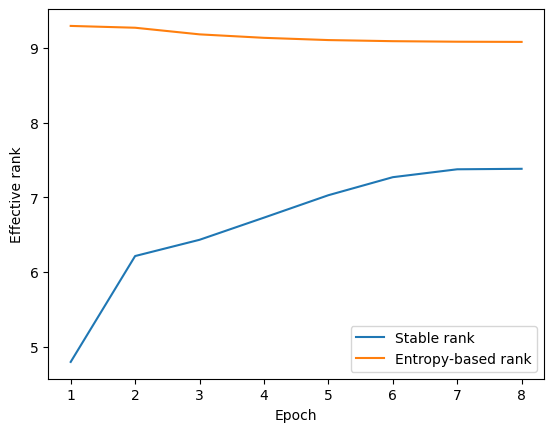

In [21]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(stable_ranks) + 1))
plt.plot(epochs, stable_ranks, label="Stable rank")
plt.plot(epochs, entropy_ranks, label="Entropy‐based rank")
plt.xlabel("Epoch")
plt.ylabel("Effective rank")
plt.legend()
plt.show()